### Загрузка модели

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as dt
from carvana_dataset import CarvanaDataset
from model import SegmenterModel
from torch.autograd import Variable
import torch.optim as optim
import os
from tqdm import *
import numpy as np
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from PIL import Image
import matplotlib.pyplot as plt

useCuda = True
n_epoch = 100
log = './log/'
train = './data/train/'
train_masks = './data/train_masks/'
test = './data/test/'
test_masks = './data/test_masks'


ds = CarvanaDataset(train, train_masks)
ds_test = CarvanaDataset(test, test_masks)

dl      = dt.DataLoader(ds, shuffle=True, num_workers=4, batch_size=64)
dl_test = dt.DataLoader(ds_test, shuffle=False, num_workers=4, batch_size=64)

In [2]:
DEVICE_ID = 2
DEVICE = torch.device('cuda:%d' % DEVICE_ID)
torch.cuda.set_device(DEVICE_ID)

In [3]:
# разделяем на 2 канала, отвечающих за пиксели автомобиля и фона соответственно
def divide_to_classes(t):
    return torch.cat((t, (torch.ones(t.size()) - t)), dim = 1)

### Обучение модели

In [4]:
global_train_loss = []
global_test_loss = []

def train_model(net):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, amsgrad=True)
    
    if useCuda == True:
        net = net.cuda()
        criterion = criterion.cuda()

    global_iter = 0
    for epoch in tqdm_notebook(range(0, n_epoch)):
        if epoch == 75:
            optimizer = optim.Adam(net.parameters(), lr=0.0001) 
        elif epoch == 90:
            optimizer = optim.Adam(net.parameters(), lr=0.00001)
            
        train_loss = 0
        net.train(True)
        for iter, (i, t) in enumerate(dl):
            i = Variable(i)
            t = Variable(divide_to_classes(t))
            if useCuda :
                i = i.cuda()
                t = t.cuda()
            o = net(i)
            loss = criterion(o, t)
            loss.backward()
            optimizer.step()

            global_iter += 1
            train_loss += loss.item()

        train_loss = train_loss / float(len(ds))
        global_train_loss.append(train_loss)
        
        
        test_loss = 0
        net.train(False)

        for iter, (i, t) in enumerate(dl_test):
            with torch.no_grad():
                i = Variable(i)
                t = Variable(divide_to_classes(t))
            if useCuda :
                i = i.cuda()
                t = t.cuda()
            o = net(i)
            loss = criterion(o, t)
            test_loss += loss.item()

        test_loss = test_loss / float(len(ds_test))
        global_test_loss.append(test_loss)
        print("Epoch: {} Train_loss: {} Test_loss: {}".format(epoch, train_loss, test_loss))

In [5]:
net = SegmenterModel()
train_model(net)

Epoch: 0 Train_loss: 0.008211259172993457 Test_loss: 0.011061103559854462
Epoch: 1 Train_loss: 0.00708787167957256 Test_loss: 0.006629325390800717
Epoch: 2 Train_loss: 0.006245164234825617 Test_loss: 0.005737566513808694
Epoch: 3 Train_loss: 0.005480411316890383 Test_loss: 0.005300447344779968
Epoch: 4 Train_loss: 0.004918932719522168 Test_loss: 0.005776107956574658
Epoch: 5 Train_loss: 0.004450351670059054 Test_loss: 0.00517585920536612
Epoch: 6 Train_loss: 0.0041132935920657025 Test_loss: 0.004051115510501261
Epoch: 7 Train_loss: 0.0038971705565546276 Test_loss: 0.003960367702827679
Epoch: 8 Train_loss: 0.003668400414255509 Test_loss: 0.003921802647001161
Epoch: 9 Train_loss: 0.0033697122244335156 Test_loss: 0.0034121914700729642
Epoch: 10 Train_loss: 0.0030876335325980293 Test_loss: 0.0032965946854568843
Epoch: 11 Train_loss: 0.0028940285820367555 Test_loss: 0.002796811469661908
Epoch: 12 Train_loss: 0.0022942645483402186 Test_loss: 0.0020912379085078953
Epoch: 13 Train_loss: 0.0020

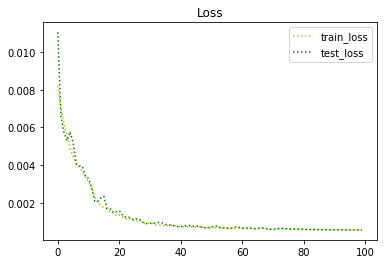

In [6]:
plt.title('Loss')
plt.plot(global_train_loss, 'y:', label = 'train_loss')
plt.plot(global_test_loss, 'g:', label = 'test_loss')
plt.legend()

### Результаты

In [7]:
# превращаем два канала в один, классифицируя пиксели
def pixe_wise_img(input):
    output = torch.zeros(1, input.size()[2], input.size()[3])
    for i in range(input.size()[2]):
        for j in range(input.size()[3]):
            if input[0, 0, i, j] > input[0, 1, i, j]:
                output[0, i, j] = 1
            else:
                output[0, i, j] = 0        
    return output

# генерируем изображение на основе полученного тензора
def tensorToImg(tensors, figsize):
    plt.figure(figsize=figsize)
    for i, tensor in enumerate(tensors):
        img = ToPILImage()(tensor.cpu())
        sp = plt.subplot(1, len(tensors), i+1)
        sp.imshow(img)
    plt.show()

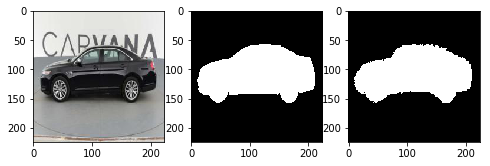

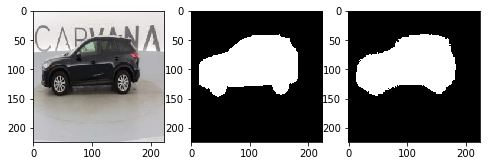

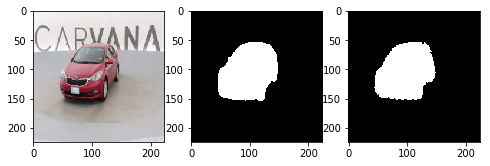

In [8]:
# рандомный выбор нескольких изображений
import random
for i in range(3):
    input, output = ds_test[random.randint(0, 99)]

    input = Variable(input.unsqueeze_(0)).cuda()
    prediction = pixe_wise_img(net(input))
    
    tensorToImg((input.squeeze_(0), output, prediction), figsize=(8,24))